# Assignment 3

* Using the CamVid (URLs.CAMVID) dataset train a UNet to at least 93% accuracy
* Once your model is trained, export it
* Take 3 of your own pics at street view of scenes that may contain roads, cars, people, buildings, trees, grass, bushes, etc (in any combination)
* Load the model from the export.
* Using each of the pics you took, create a prediction using the model you loaded.
* Show the pic, with the prediction overlaied on top of the pic.  the figure size should be (12,12).
* You may do this in 3 separate cells if you wish

After your predictions, answer the following questions in a separate markdown cell:
* How good was your model at predicting this "holdout" test set?  Where is it having difficulty or particular success?
* Describe 2 strategies that you could legitimately use, with the resources you have, to increase this quality.

In [1]:
#!curl -s https://course.fast.ai/setup/colab | bash

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/xct/.fastai/data/camvid/labels'),
 PosixPath('/home/xct/.fastai/data/camvid/images'),
 PosixPath('/home/xct/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/xct/.fastai/data/camvid/valid.txt')]

In [3]:
path_lbl = path/'labels'
path_img = path/'images'
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

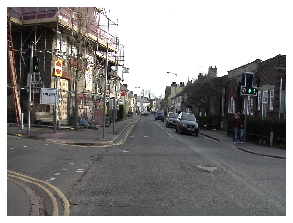

In [4]:
# look at example image
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

/home/xct/.fastai/data/camvid/labels/Seq05VD_f05010_P.png


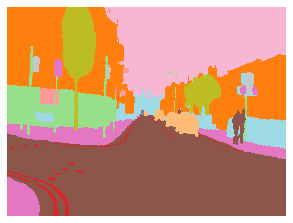

In [5]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}' # not sure what this does, this is just the filename of the label image
print(get_y_fn(img_f))
# this mask, is handlabeled data, where every pixel was classified by a human
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [6]:
# this converts the pixels into numbers we can use as inputs for models
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [7]:
# the textual labels, that match the numbers we had just before
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

<class 'numpy.ndarray'>
using bs=8, have 16118MB of GPU RAM free


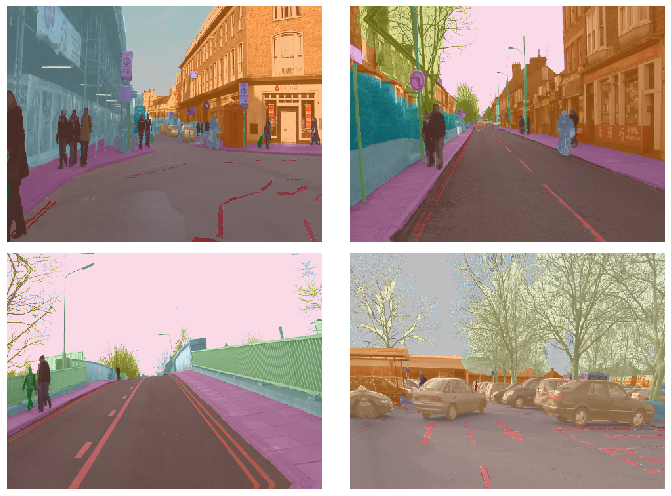

In [8]:
size = src_size//2
print(type(size))

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8 # 1
else:           bs=4 # 1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

# load the data
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

data.show_batch(2, figsize=(10,7)) # ds_type=DatasetType.Valid

In [9]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()
metrics=acc_camvid

wd=1e-2
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


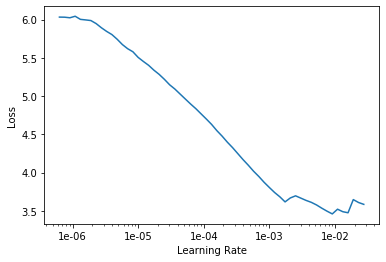

In [10]:
lr_find(learn)
learn.recorder.plot()

In [11]:
lr=3e-3 # because the loss is fairly small here
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.422502,0.969367,0.764670,00:34
1,0.904056,0.644804,0.837547,00:31
2,0.713793,0.506000,0.862247,00:31
3,0.641057,0.479994,0.863357,00:31
4,0.628521,0.480062,0.860554,00:31
5,0.588829,0.462471,0.887155,00:31
6,0.780713,0.952228,0.719246,00:31
7,0.644370,0.432685,0.882915,00:31
8,0.577786,0.479734,0.865430,00:31
9,0.493274,0.356531,0.891895,00:31


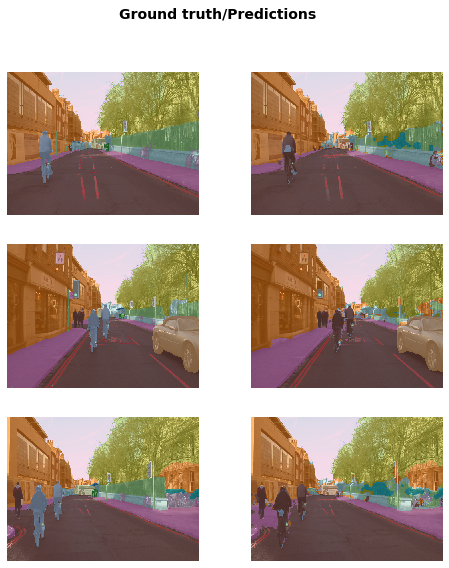

In [12]:
learn.save('stage-1')
learn.load('stage-1')
learn.show_results(rows=3, figsize=(8,9))

In [13]:
learn.unfreeze()
lrs = slice(lr/400,lr/4) # we take only everything from 1/400 to 1/4 of the learning rate to optimize it a bit
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.427131,0.341966,0.897959,00:32
1,0.420145,0.337306,0.896708,00:32
2,0.405469,0.325210,0.900678,00:32
3,0.386302,0.312553,0.908341,00:32
4,0.385068,0.322142,0.907957,00:32
5,0.372687,0.320171,0.911258,00:32
6,0.359139,0.310643,0.909400,00:32
7,0.344796,0.298606,0.914294,00:32
8,0.332549,0.312192,0.912594,00:32
9,0.330204,0.279528,0.923046,00:32


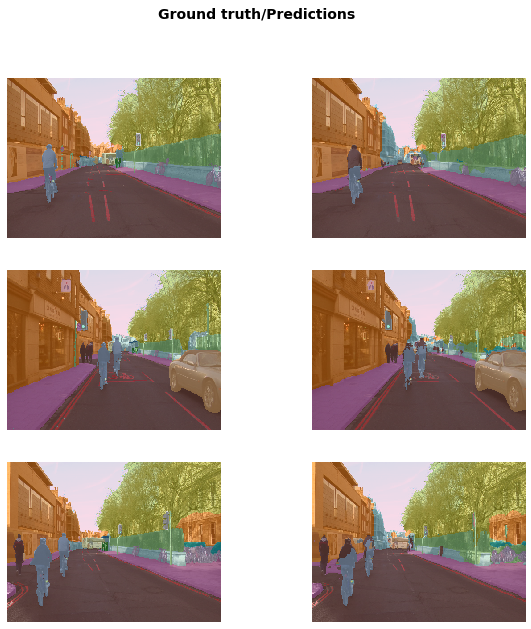

In [15]:
learn.save('stage-2');
learn.show_results(rows=3, figsize=(10,10))

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 15121MB of GPU RAM free


epoch,train_loss,valid_loss,acc_camvid,time
0,0.382221,0.351676,0.903712,02:11
1,0.368291,0.327380,0.905435,02:02
2,0.336865,0.322188,0.906718,02:02
3,0.337785,0.318697,0.912465,02:03
4,0.340550,0.319156,0.912780,02:03
5,0.368700,0.343940,0.907689,02:02
6,0.329736,0.383840,0.902174,02:02
7,0.326506,0.331652,0.911334,02:02
8,0.291528,0.295698,0.915087,02:02
9,0.237990,0.251784,0.930554,02:02


epoch,train_loss,valid_loss,acc_camvid,time
0,0.231987,0.243098,0.933033,02:07
1,0.227096,0.244786,0.930868,02:06
2,0.221099,0.260782,0.927965,02:06
3,0.217750,0.249768,0.929243,02:06
4,0.213214,0.241939,0.931914,02:06
5,0.205329,0.250284,0.931567,02:07
6,0.206191,0.240038,0.932558,02:06
7,0.193655,0.243037,0.932920,02:06
8,0.190863,0.239390,0.934104,02:06
9,0.195091,0.240049,0.934089,02:07


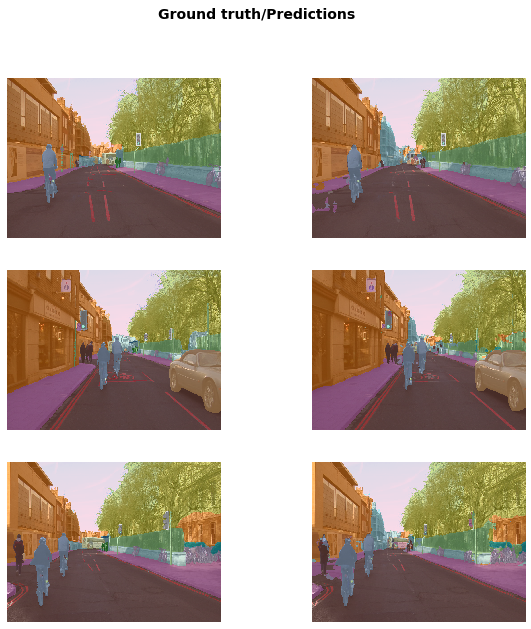

In [16]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
learn.load('stage-2')

lr=1e-3
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)
learn.save('stage-1-big')
learn.load('stage-1-big')
learn.unfreeze()
lrs = slice(1e-6,lr/10)
learn.fit_one_cycle(10, lrs)
learn.save('stage-2-big')
learn.load('stage-2-big')
learn.show_results(rows=3, figsize=(10,10))

In [28]:
import os
learn.path = Path("/data/home/xct/notebooks")
learn.export()
#!cp /home/xct/.fastai/data/camvid/images/export.pkl /data/home/xct/notebooks

/data/home/xct/notebooks
/data/home/xct/notebooks


Model trained on Azure up to this point & exported. So we do a "fresh" start where we just use the model.

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()
metrics=acc_camvid

learn = load_learner(".") # load pkl

C:\Users\xct\Anaconda3\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\xct\Anaconda3\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\xct\Anaconda3\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute 

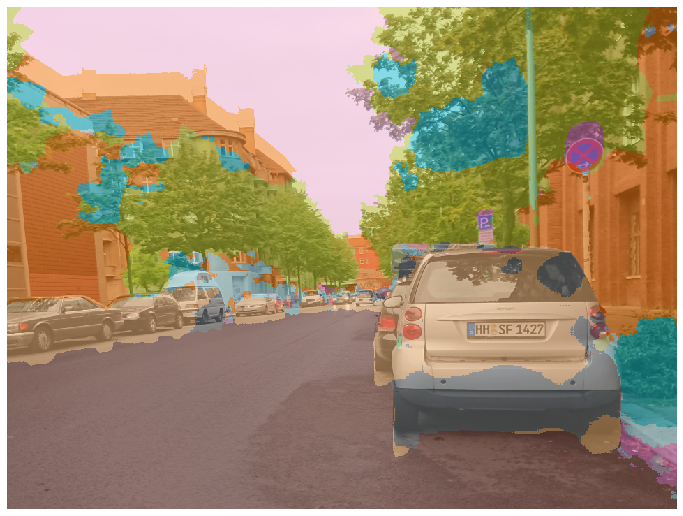

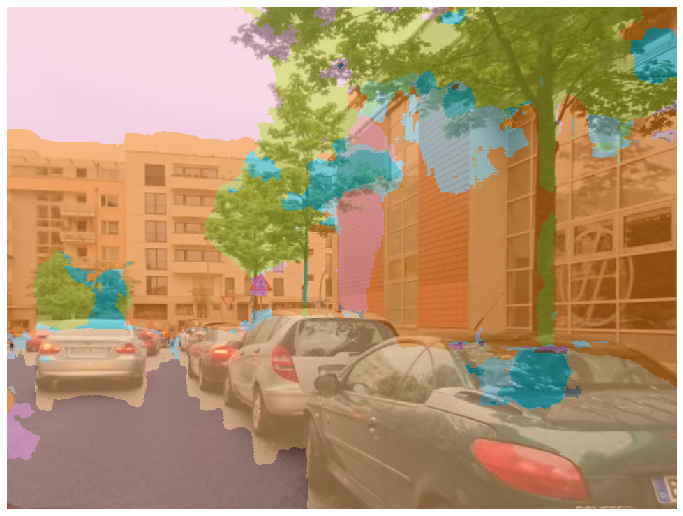

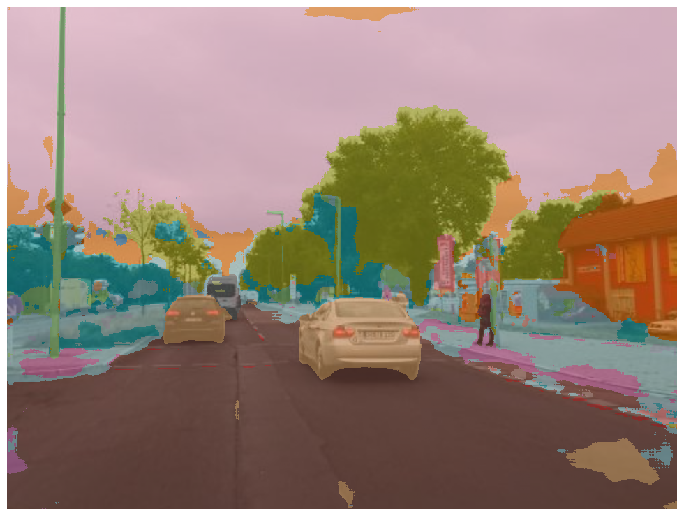

In [51]:
path_img = Path('images_a3/')


fnames = get_image_files(path_img)
for img_f in fnames:
    img = open_image(img_f)
    mask, tensor, losses = learn.predict(img) # prediction is a ImageSegment (segmentation mask)
    img = img.resize(mask.shape)
    img.show(figsize=(12,12), y=mask)

## How good was your model at predicting this "holdout" test set? Where is it having difficulty or particular success?

It is looking not too bad. While it seems to have difficulties with the 2nd picture where it "sees" a sidewalk (purple) going up straight to the sky and in the third picture it "sees" a lot of people left and right (blue) that are not really present, it is overall pretty good at recognizing the different objects. Here and there are some artifacts though.

What is also interesting is that I used different resolutions. The first image is of high quality while the other 2 are of lower quality. This seems to influence the quality of the predictions a bit aswell.


## Describe 2 strategies that you could legitimately use, with the resources you have, to increase this quality.

One possibility is to use resnet50 instead of resnet34. I did not do this, because it would cost me more ressources on azure, but I believe it might be able to achieve slightly better results. Meta-Parameters we can play with to improve the performance are: wd (weight decay), pct_start (percentage of epochs in one cycle on changing lr?), learning rate, number of cycles. For a kaggle competition I would probably play with these and see how to result changes.

We also could always get more data but that would be very difficult as it requires labeling by hand.